In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import squidpy as sq
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sys
from transpa.util import expVeloImp, leiden_cluster, expDeconv
import torch
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# load preprocessed scRNA-seq and spatial datasets
RNA = scv.read('../../data/Mouse_brain/RNA_adata.h5ad')
HybISS = scv.read('../../data/Mouse_brain/HybISS_adata.h5ad')
RNA, HybISS

(AnnData object with n_obs × n_vars = 40733 × 16907
     obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
     var: 'GeneName', 'gene_count_corr'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 4628 × 119
     obs: 'n_counts'
     var: 'GeneName'
     obsm: 'X_xy_loc', 'xy_loc')

In [2]:
RNA.obs

CellID    Age     Region     Tissue         Class  \
0      10X40_3_A_1:CGAGGCACTAGAGAx  e11.0  Hindbrain  Hindbrain  Gastrulation   
1      10X40_3_A_1:TGTTAAGATCTCTAx  e11.0  Hindbrain  Hindbrain  Gastrulation   
2      10X40_3_A_1:GGAACTTGCTAGCAx  e11.0  Hindbrain  Hindbrain  Gastrulation   
3      10X40_3_A_1:CAGGTTGATGAAGAx  e11.0  Hindbrain  Hindbrain  Gastrulation   
4      10X25_5_A_1:AAATCCCTCTTAGGx  e10.0  Forebrain  Forebrain  Gastrulation   
...                            ...    ...        ...        ...           ...   
40728  10X40_6_A_1:ATCGGTGATTCAGGx  e11.0   Midbrain   Midbrain        Neuron   
40729  10X27_7_A_1:CCTCTACTCTTCCGx  e11.0  Forebrain  Forebrain        Neuron   
40730  10X27_7_A_1:CGTTAGGAATGCTGx  e11.0  Forebrain  Forebrain        Neuron   
40731  10X27_7_A_1:ATCTGGGAGTCACAx  e11.0  Forebrain  Forebrain        Neuron   
40732  10X40_4_A_1:ATCACTTGATGCCAx  e11.0   Midbrain   Midbrain        Neuron   

                         Subclass  initial_size_spliced  \
0                Cardiac mesoderm                  2691   
1                Cardiac mesoderm                  3952   
2                Cardiac mesoderm                  3007   
3                Cardiac mesoderm                  3322   
4          Osteochondral mesoderm                  4071   
...                           ...                   ...   
40728  Diencephalon glutamatergic                  1330   
40729  Diencephalon glutamatergic                  2347   
40730  Diencephalon glutamatergic                  1968   
40731  Diencephalon glutamatergic                   742   
40732  Diencephalon glutamatergic                  3189   

       initial_size_unspliced  initial_size     n_counts  
0                         552        3460.0  993352.6250  
1                         934        5182.0  988035.4375  
2                         923        4222.0  990525.7500  
3                         958        4572.0  986876.6250  
4                         656        5070.0  997436.0000  
...                       ...           ...          ...  
40728                     660        2193.0  996352.0000  
40729                     829        3444.0  997677.1250  
40730                    1050        3230.0  994117.6875  
40731                     529        1360.0  995588.2500  
40732                     846        4372.0  996111.6250  

[40733 rows x 10 columns]

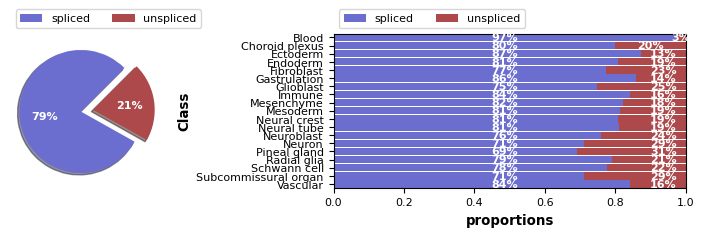

Extracted 2031 highly variable genes.


In [3]:
scv.pl.proportions(RNA, 'Class')
scv.pp.filter_and_normalize(RNA, n_top_genes=2000, retain_genes=HybISS.var_names)

In [4]:
scv.pp.moments(RNA, n_pcs=30, n_neighbors=30)
sc.tl.umap(RNA)
scv.tl.velocity(RNA, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(RNA, vkey='stc_velocity', n_jobs=10)

computing neighbors
    finished (0:00:36) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:28) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/96 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:55) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:08) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


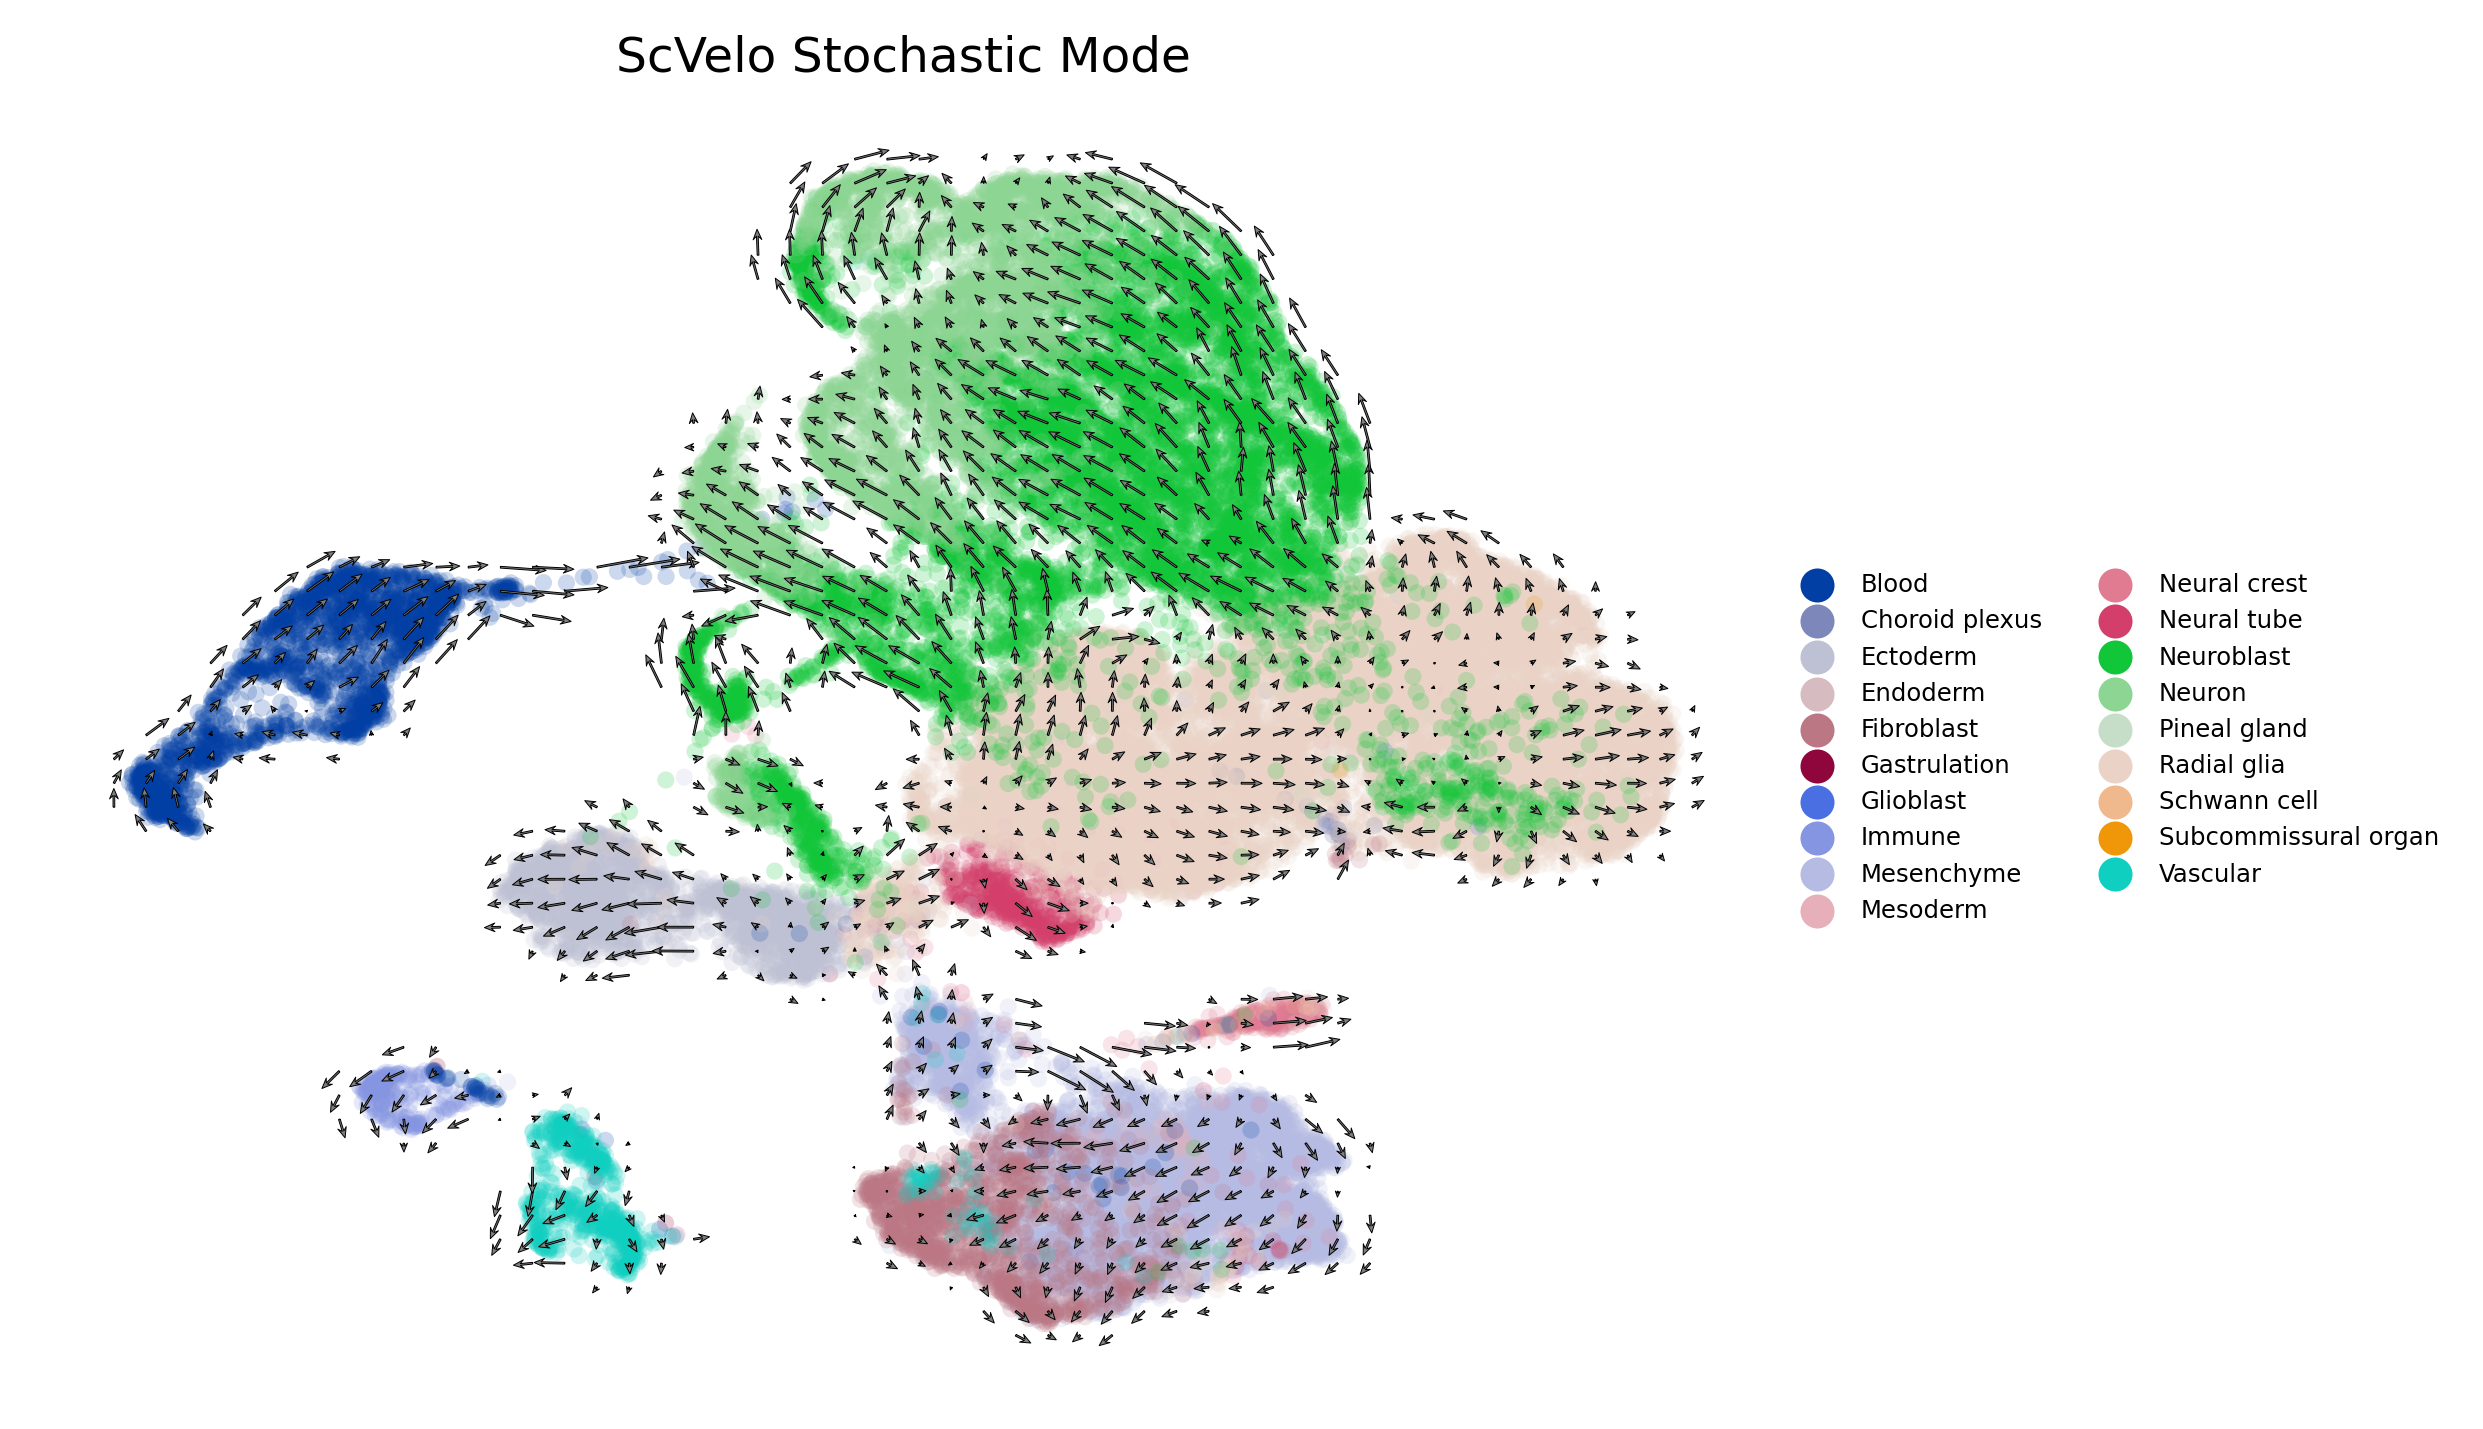

In [5]:
scv.pl.velocity_embedding_grid(RNA,  
                                vkey="stc_velocity", 
                                basis='X_umap', color="Class",
                                legend_fontsize=5,
                                size=50,
                                legend_loc='right',
                                arrow_length=2,
                                dpi=350, 
                                title='ScVelo Stochastic Mode')

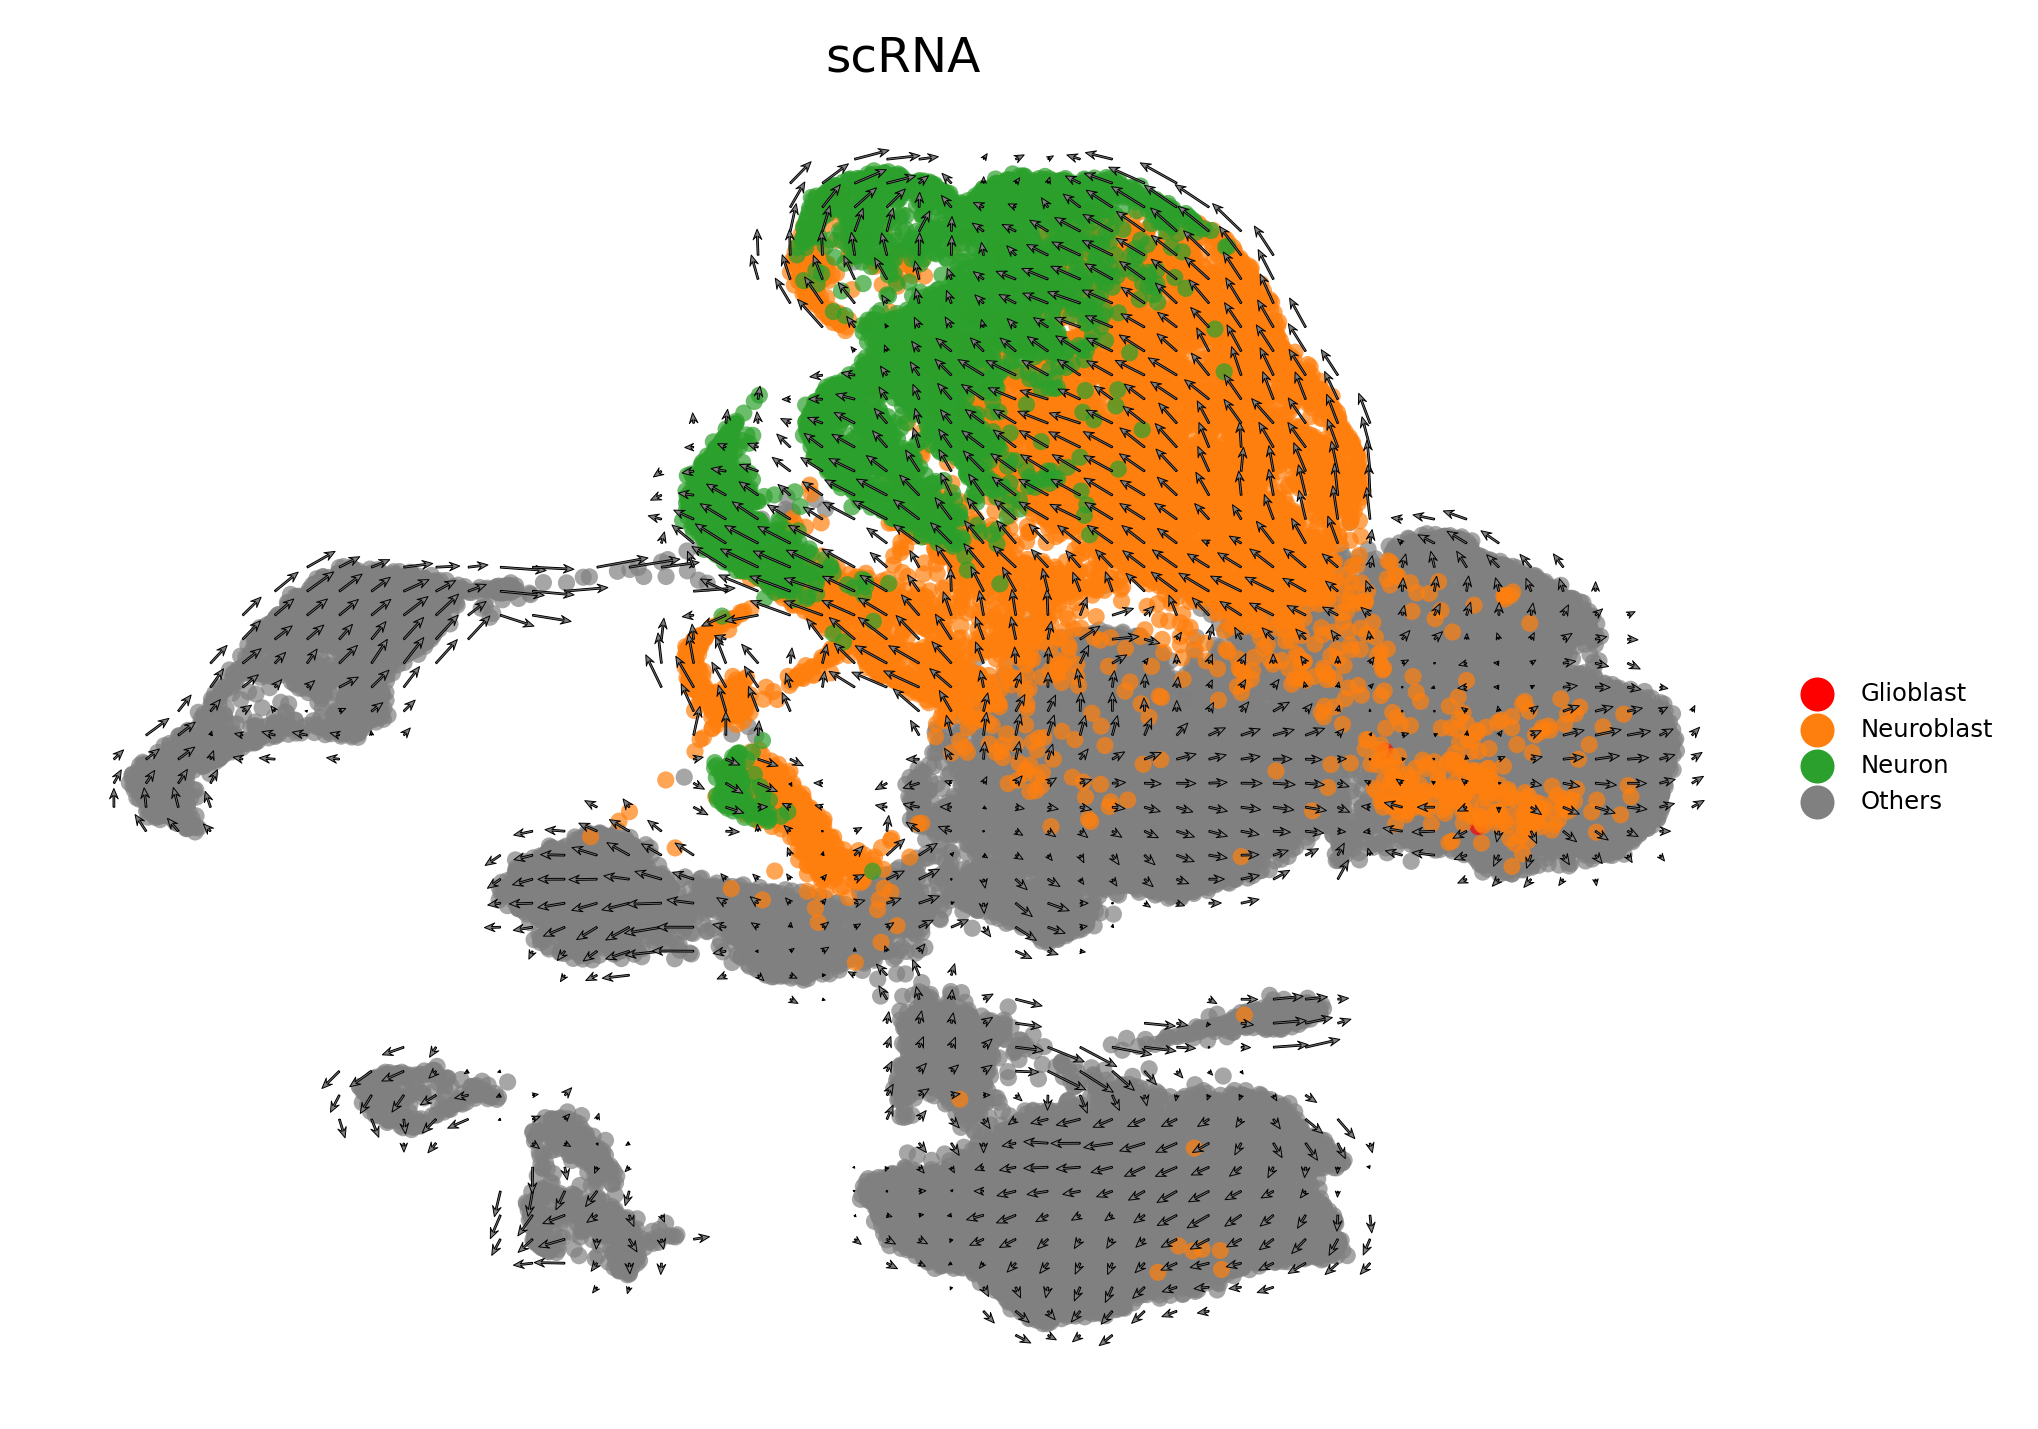

In [6]:
RNA.obs["Class_agg"] = list(map(lambda x: x if x in {"Neuron", "Glioblast", "Neuroblast"} else "Others", RNA.obs.Class.values))
RNA.uns['Class_agg_colors'] = ['#ff0000', '#ff7f0e', '#2ca02c', '#808080']

scv.pl.velocity_embedding_grid(RNA,  
                                vkey="stc_velocity", 
                                basis='X_umap', color="Class_agg",
                                legend_fontsize=5,
                                size=50,
                                alpha=.7,
                                arrow_length=2,
                                legend_loc='right',
                                dpi=350, 
                                title='scRNA')                                

In [7]:
RNA

AnnData object with n_obs × n_vars = 40733 × 2031
    obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'Class_agg'
    var: 'GeneName', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'Class_colors', 'Class_agg_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

In [8]:
sc.pp.pca(HybISS, n_comps=30)
celltype_counts = RNA.obs['Class'].value_counts()

celltype_drop = celltype_counts.index[celltype_counts < 2]
rna_adata = RNA.copy()
if len(celltype_drop):
    print(f'Drop celltype {list(celltype_drop)} contain less 2 sample')
    rna_adata = RNA[~RNA.obs['Class'].isin(celltype_drop),].copy()
sc.tl.rank_genes_groups(rna_adata, groupby="Class", use_raw=False)
markers_df = pd.DataFrame(rna_adata.uns["rank_genes_groups"]["names"]).iloc[0:100, :]

genes_sc = np.unique(markers_df.melt().value.values)

gene = np.intersect1d(genes_sc, HybISS.var_names)
rna_adata = rna_adata[:, gene].copy()
spa_adata = HybISS[:, gene].copy()

df_ref = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)
df_tgt = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

shared_gene = np.intersect1d(df_ref.columns, df_tgt.columns)
df_ref = df_ref[shared_gene]
df_tgt = df_tgt[shared_gene]
classes = rna_adata.obs.Class.values
ct_list = np.unique(classes)    

preds, weight = expDeconv(
            df_ref=df_ref, 
            df_tgt=df_tgt, 
            classes=classes,
            ct_list=ct_list,
            n_epochs=8000,
            lr=1e-2,
            seed=seed,
            device=device
            ) 

cmps = weight

df_results = pd.DataFrame(cmps, columns=ct_list)

df_results = (df_results.T/df_results.sum(axis=1)).T
HybISS.obs['Class'] = df_results.columns[np.argmax(df_results.values, axis=1)]

[LinTrans] Epoch: 8000/8000, loss: 1.006584: 100%|██████████| 8000/8000 [00:45<00:00, 176.80it/s]


In [9]:
np.unique(RNA.obs.Class, return_counts=True)

(array(['Blood', 'Choroid plexus', 'Ectoderm', 'Endoderm', 'Fibroblast',
        'Gastrulation', 'Glioblast', 'Immune', 'Mesenchyme', 'Mesoderm',
        'Neural crest', 'Neural tube', 'Neuroblast', 'Neuron',
        'Pineal gland', 'Radial glia', 'Schwann cell',
        'Subcommissural organ', 'Vascular'], dtype=object),
 array([ 2098,    18,  1948,     5,  1277,    15,    18,   230,  5332,
           61,   305,   550,  8369,  4302,     3, 15544,     8,     2,
          648]))

In [10]:
RNA

AnnData object with n_obs × n_vars = 40733 × 2031
    obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'Class_agg'
    var: 'GeneName', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'Class_colors', 'Class_agg_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

In [11]:
HybISS.obsm['spatial'] = HybISS.obsm['X_xy_loc']
sq.gr.spatial_neighbors(HybISS, coord_type='generic', n_neighs=10)


In [12]:
HybISS

AnnData object with n_obs × n_vars = 4628 × 119
    obs: 'n_counts', 'Class'
    var: 'GeneName'
    uns: 'pca', 'spatial_neighbors'
    obsm: 'X_xy_loc', 'xy_loc', 'X_pca', 'spatial'
    varm: 'PCs'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [13]:
raw_spatial_df  = pd.DataFrame(HybISS.X, columns=HybISS.var_names)
raw_scrna_df    = pd.DataFrame(RNA.X, columns=RNA.var_names).astype(pd.SparseDtype("float32", 0))
raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((4628, 119), (40733, 2031), (117,))

In [14]:
RNA

AnnData object with n_obs × n_vars = 40733 × 2031
    obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'Class_agg'
    var: 'GeneName', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'Class_colors', 'Class_agg_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

In [15]:
res = expVeloImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            S=RNA.layers['spliced'],
            U=RNA.layers['unspliced'],
            V=RNA.layers['spliced'],
            train_gene=raw_shared_gene,
            test_gene=RNA.var_names,
            signature_mode='cell',
            mapping_mode='lowrank', 
            # classes='celltype_prediction', 
            # spa_adj=Visium.obsp['spatial_connectivities'].tocoo(),
            n_epochs=1000,
            seed=seed,
            device=device)
S, U, V, X = res

[TransImp] Epoch: 1000/1000, loss: 0.447701, (IMP) 0.447701: 100%|██████████| 1000/1000 [00:04<00:00, 208.04it/s]


In [16]:
imp_adata = sc.AnnData(X)
imp_adata.obs = HybISS.obs.copy()
imp_adata.obsm = HybISS.obsm.copy()
imp_adata.var_names = RNA.var_names
imp_adata.obs_names = HybISS.obs_names
imp_adata.uns = HybISS.uns
imp_adata.uns['Class_colors'] = RNA.uns['Class_colors']

imp_adata.layers['spliced'] = S
imp_adata.layers['unspliced'] = U

scv.pp.normalize_per_cell(imp_adata, enforce=True)
sc.pp.scale(imp_adata)
sc.tl.pca(imp_adata)
sc.pp.neighbors(imp_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(imp_adata)
sc.tl.leiden(imp_adata)


scv.pp.moments(imp_adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(imp_adata, vkey='stc_velocity')
scv.tl.velocity_graph(imp_adata, vkey='stc_velocity', n_jobs=10)
scv.tl.velocity_confidence(imp_adata, vkey='stc_velocity')

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/96 cores)
    finished (0:00:03) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_xy_loc', embedded velocity vectors (adata.obsm)


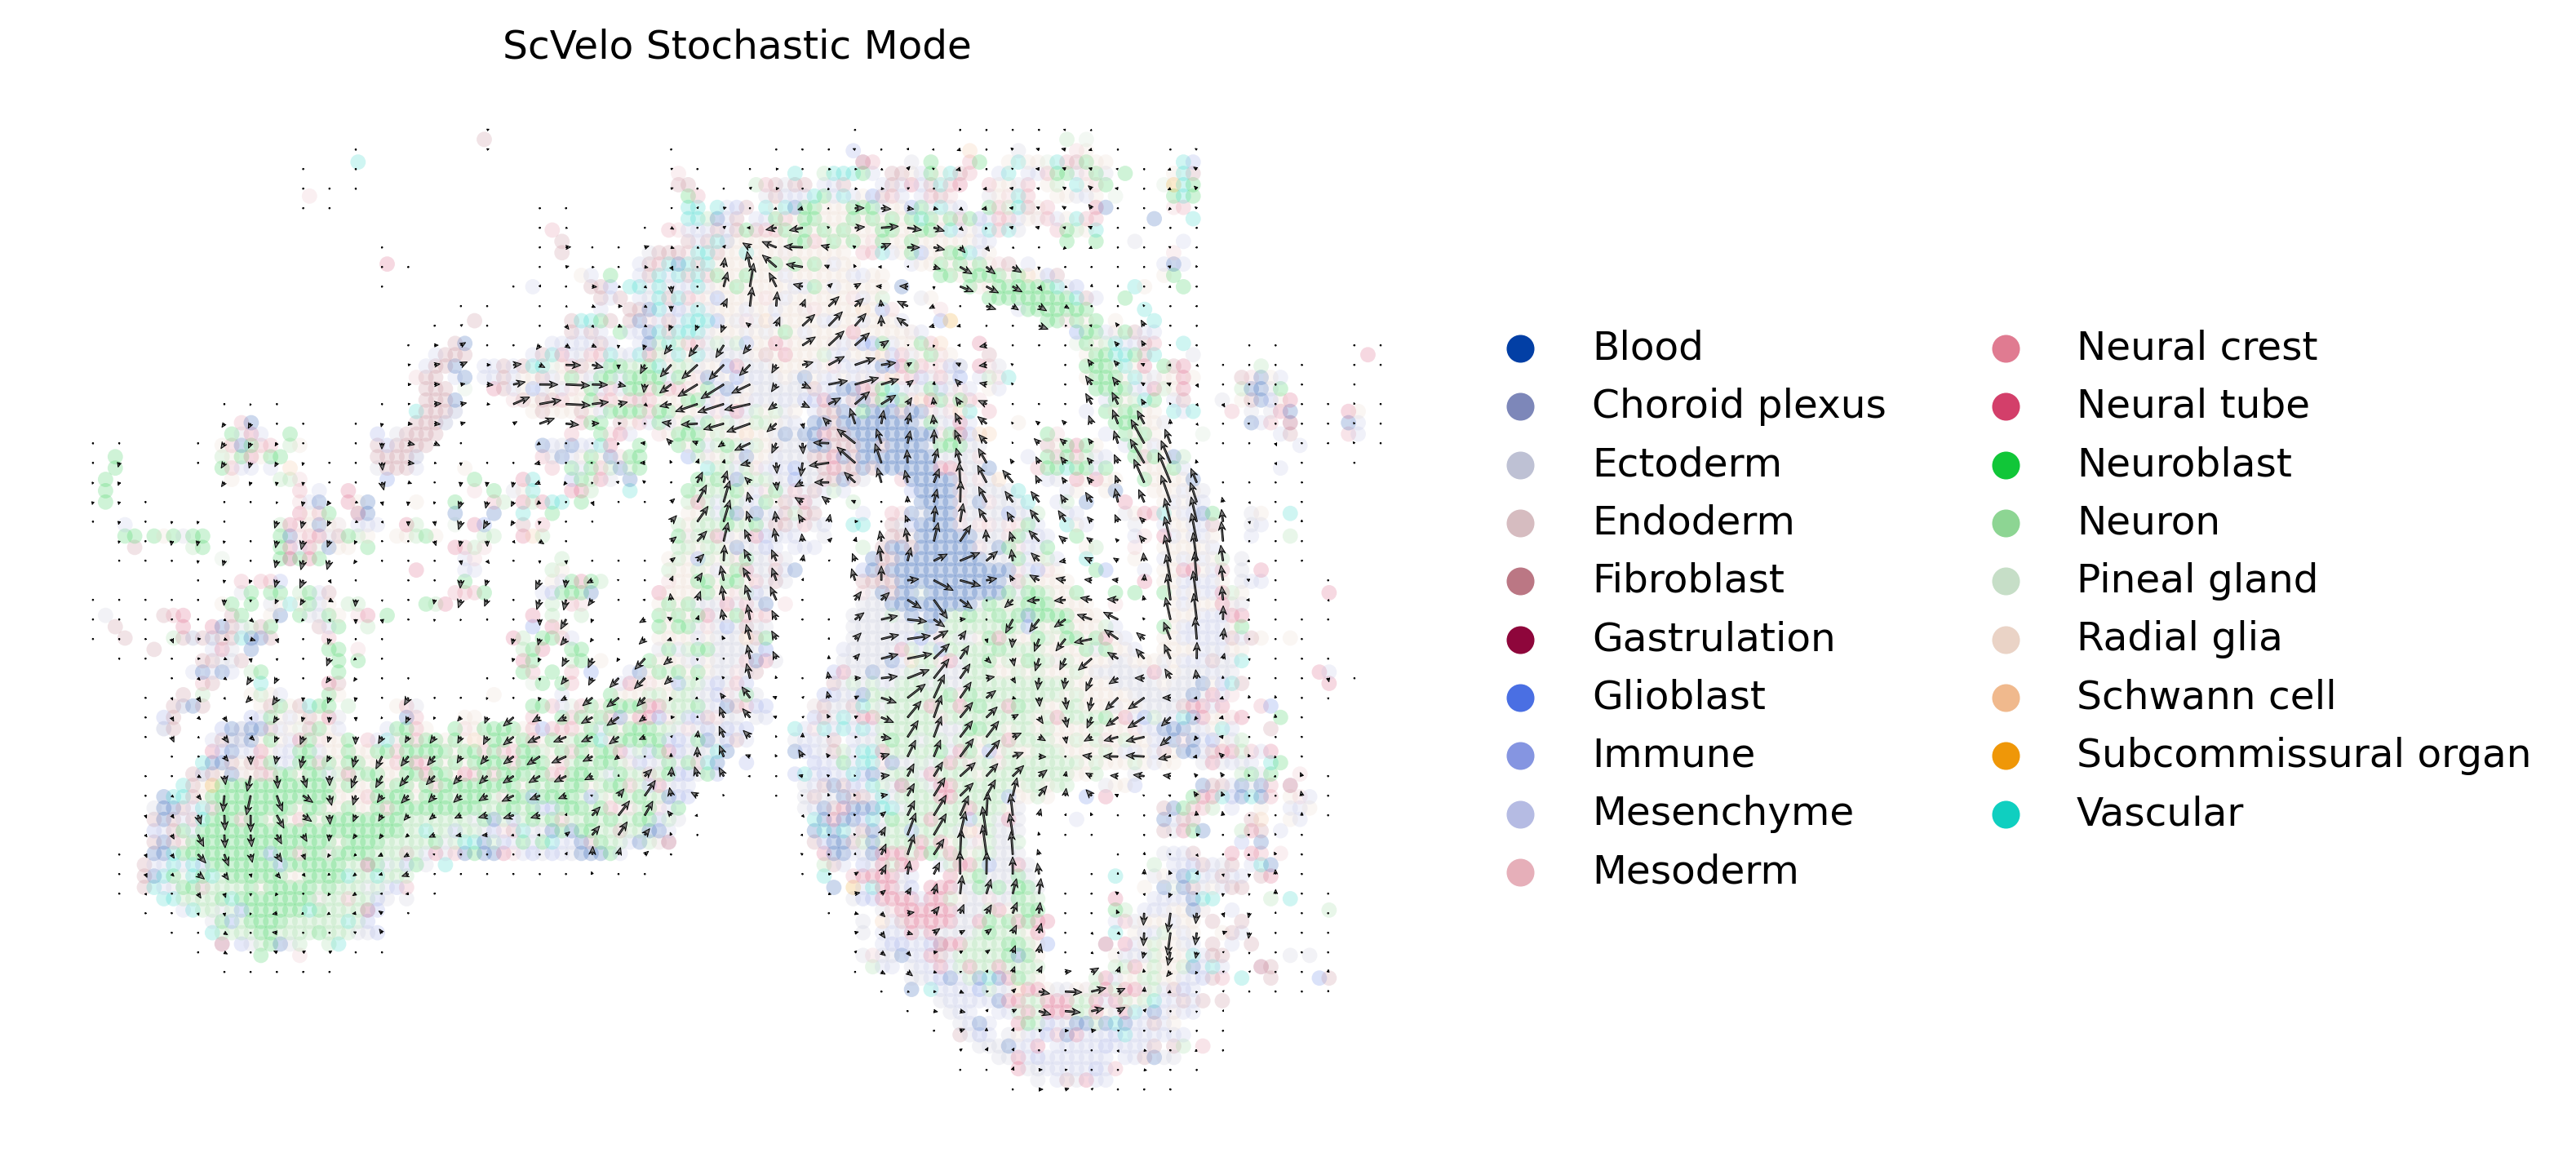

In [17]:
scv.pl.velocity_embedding_grid(imp_adata,  
                                vkey="stc_velocity", 
                                basis='xy_loc', color="Class",
                                # legend_fontsize=2,
                                size=60,
                                legend_loc='right',
                                # smooth=0.5,
                                dpi=350, 
                                title='ScVelo Stochastic Mode')

In [18]:
imp_adata.obs["Class_agg"] = list(map(lambda x: x if x in {"Neuron", "Glioblast", "Neuroblast"} else "Others", imp_adata.obs.Class.values))
imp_adata.uns['Class_agg_colors'] = ['#ff0000', '#ff7f0e', '#2ca02c', '#808080']

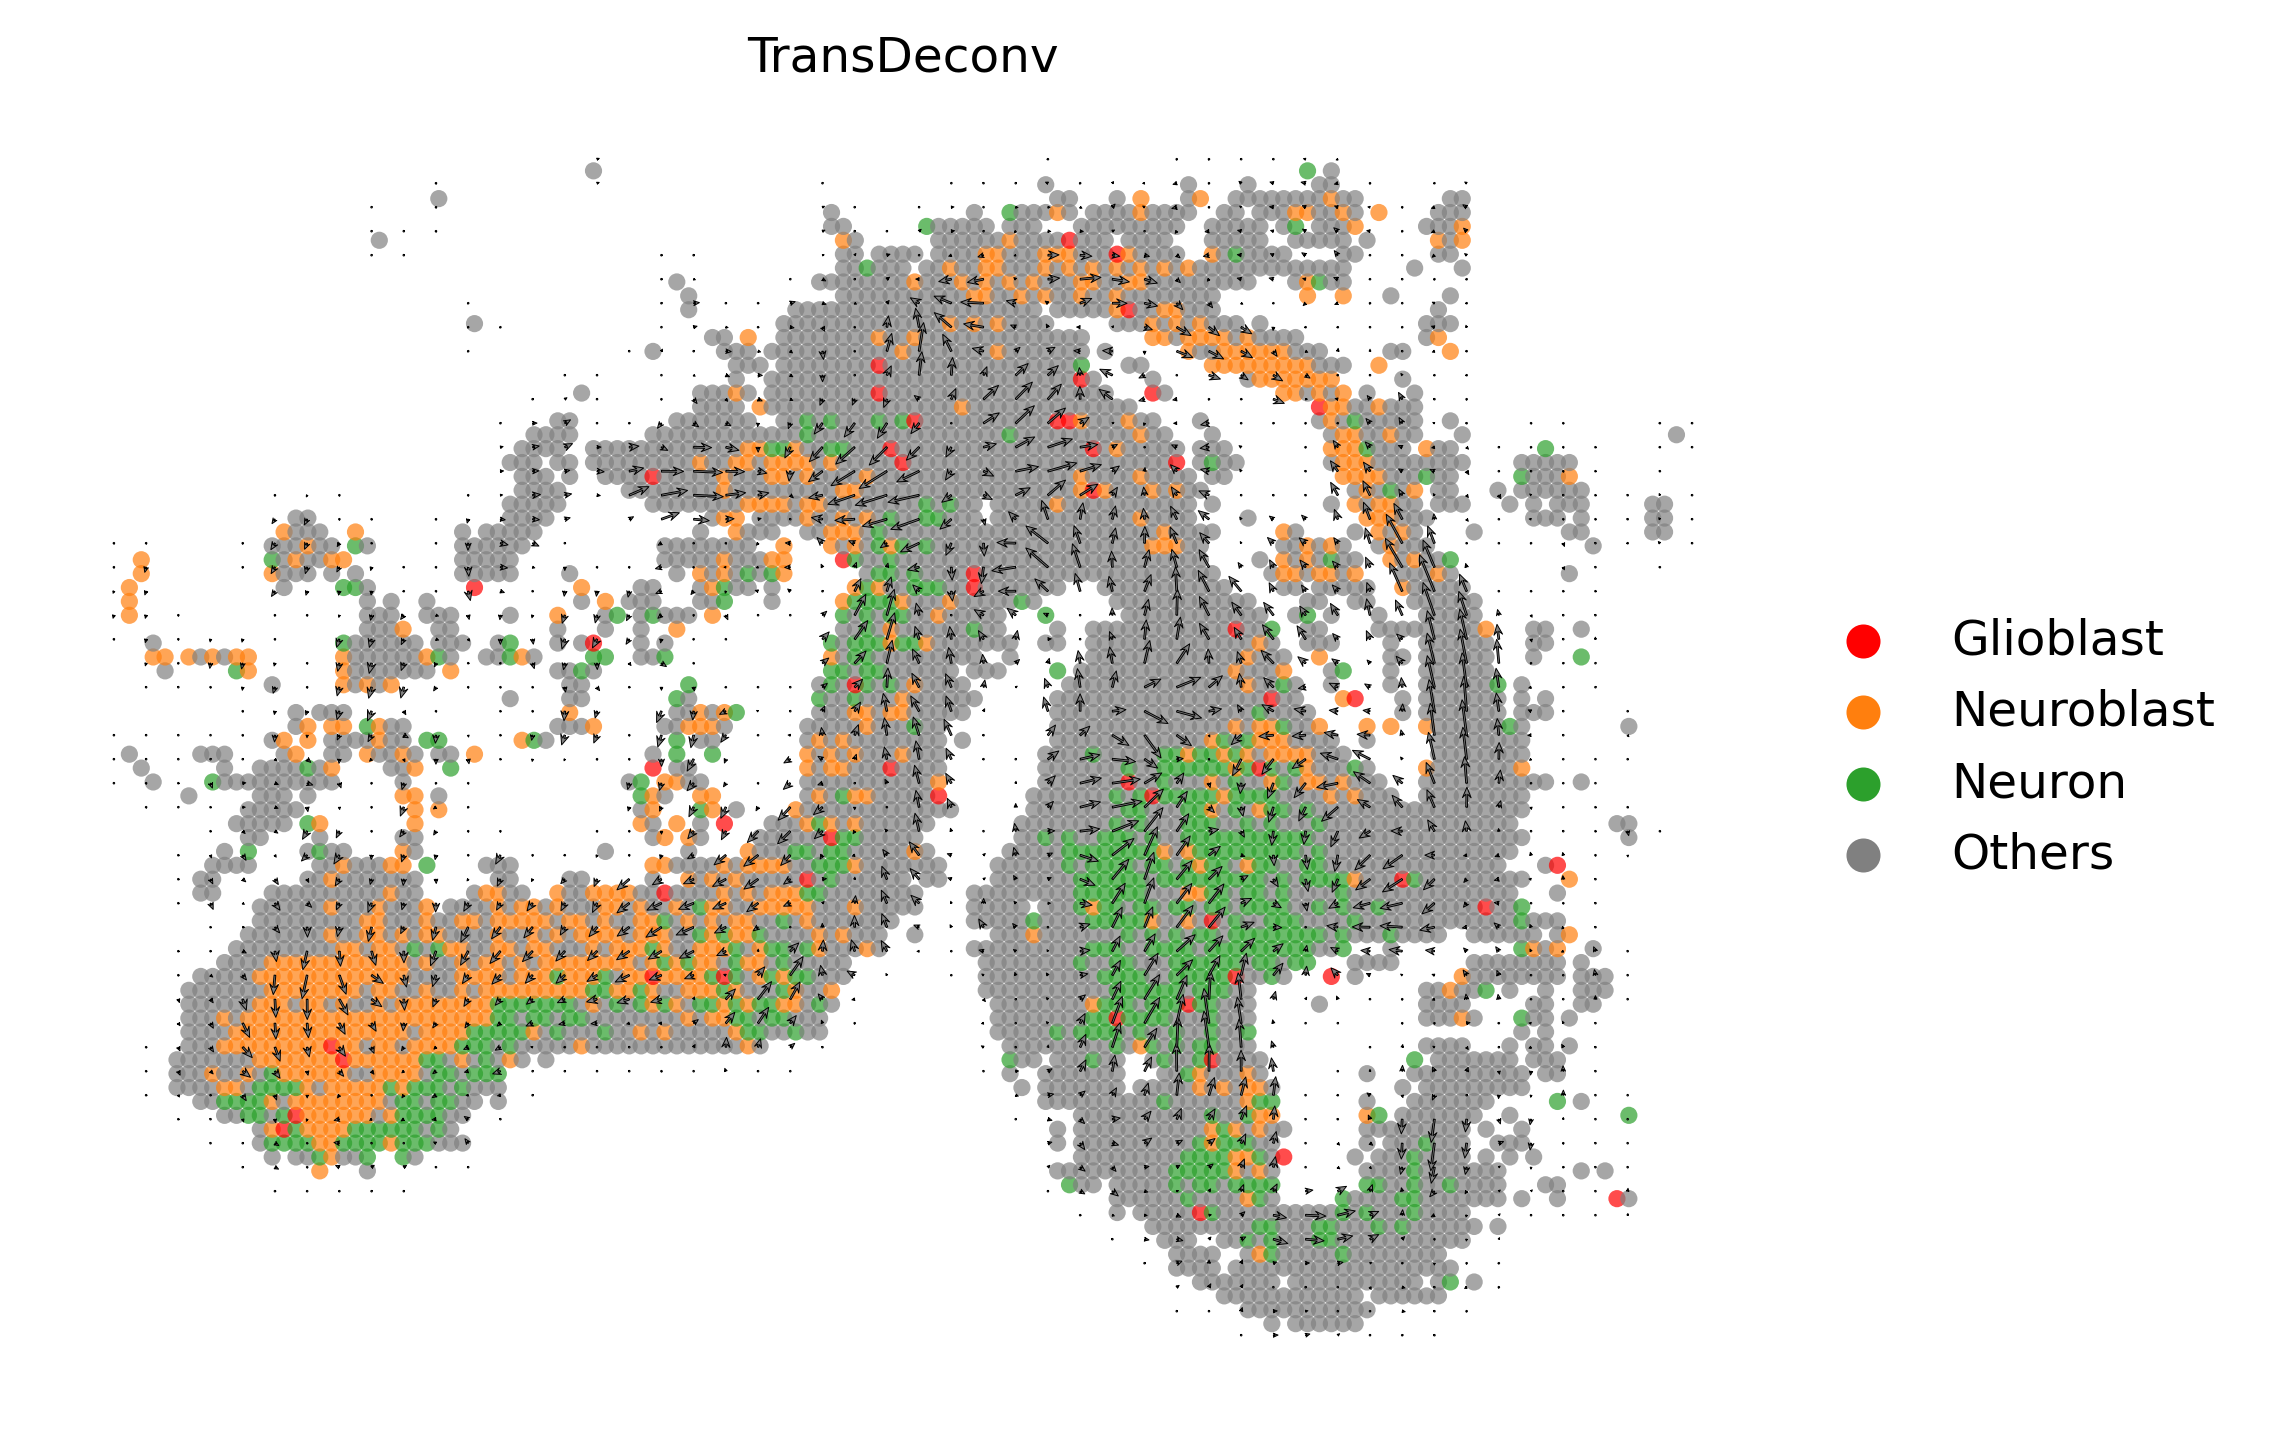

In [19]:

scv.pl.velocity_embedding_grid(imp_adata,  
                                vkey="stc_velocity", 
                                basis='xy_loc', color="Class_agg",
                                # legend_fontsize=2,
                                size=50,
                                legend_loc='right',
                                alpha=.7,
                                # smooth=0.5,
                                dpi=350, 
                                title='TransDeconv')                          